<b style="font-size:34px; line-height:1.2"><center>Модель монетизации игрового приложения</b></center>

Данные содержат иформацию о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

**Основная задача:** сформировать модель монетизации игрового приложения.

**Этапы достижения основной задачи:**
 - загрузить данные и подготовить их к анализу;
 - рассчитать продуктовые метрики;
 - рассчитать маркетинговые метрики;
 - написать выводы и дать рекомендацию.

# Шаг №1.  Загрузить данные и изучить их

<b style="font-size:18px; line-height:1.2"><center>Структура данных</b></center>


**game_actions.csv** (в датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно):
    
- `event_datetime` — время события;


- `event` — одно из трёх событий:
    1. *building* — объект построен,
    2. *finished_stage_1* — первый уровень завершён,
    3. *project* — проект завершён;
    
    
- `building_type` — один из трёх типов здания:
    1. *assembly_shop* — сборочный цех,
    2. *spaceport* — космопорт,
    3. *research_center* — исследовательский центр;
    
    
- `user_id` — идентификатор пользователя;


- `project_type` — тип реализованного проекта;


**ad_costs.csv** содержит колонки:


- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

**user_source.csv** содержит колонки:


- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

Установим свежую версию библиотеки Plotly:

In [1]:
pip install plotly==5.1.0

Импортируем необходимые библиотеки:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as st

Оценив данные, создадим пайплайн для загрузки полного датасета `game_actions`, `ad_costs` и `user_source`. Таким способом мы сразу преобразуем временные данные в необхимый тип, а также столбцы с категориальными данными преобразуем в категориальный тип. Следствием наших действий уменьшится занимаемая память DF. 

In [3]:
game_actions = pd.read_csv('game_actions.csv', header=0,
    parse_dates=['event_datetime'],    
    dtype={'event': 'category', 'building_type' : 'category'})

ad_costs = pd.read_csv('ad_costs.csv', header=0,
    parse_dates=['day'])

user_source = pd.read_csv('user_source.csv', header=0 )

Проверим DF на дубликаты, которые можно удалить:

In [4]:
print('Количество дубликатов в game_actions:', game_actions.duplicated().sum())
game_actions = game_actions.drop_duplicates().reset_index(drop = True)

Количество дубликатов в game_actions: 1


Был обнаружен один дубликат, который никак не влияет на данные при его удалении. Соответственно, исключим его из наших данных. 

Используя код из ранее сделанных проектов, сведем информацию о всех DF в одну сводную таблицу:

In [5]:
# Создадим словарь соответствия фрейма и его имени
dict_frames ={
    'game_actions': game_actions,
    'ad_costs': ad_costs,
    'user_source': user_source,
}

# Функция, для сбора информации о всех DF
def info_frame(dict_of_frames):
    def table(dataframe, name):
        # Собираем данные из конкретной таблицы
        columns = dataframe.columns
        count_of_rows = len(columns)
        total = dataframe.shape[0]
        
        part_total_table = pd.DataFrame(data =[[0] * 5] * count_of_rows, 
                                        columns = ['total',
                                                   'frame',
                                                   "columns",
                                                   "null_values, %",
                                                   "type"])
    
        part_total_table['total'] = [total] * count_of_rows
        part_total_table['frame'] = [name] * count_of_rows
        part_total_table['columns'] = columns
        
        
        for column in columns:
            curent_type = str(dataframe[column].dtype)
            count_of_null = dataframe[column].isnull().sum() * 100 / part_total_table['total']
            part_total_table.loc[part_total_table['columns'] == column,'null_values, %'] = count_of_null.round(2)
            part_total_table.loc[part_total_table['columns'] == column,'type'] = curent_type
        
        return part_total_table
    
    # объединяем даные из каждой таблицы в одну   
    final_frame = pd.DataFrame(columns = ['total','frame',"columns","null_values, %","type"])
    
    for name,frame in dict_of_frames.items():
        part_of_table = table(frame,name)
        final_frame = final_frame.append(part_of_table)
        
    final_frame = final_frame.reset_index(drop = True)
    final_frame_grouped = final_frame.groupby(['total','frame',"columns"]).first()
    final_frame_grouped = final_frame_grouped.style.background_gradient(cmap='Blues',subset=['null_values, %'])
    
    return final_frame_grouped

In [6]:
info_frame(dict_frames)

**Вывод:** В DF *game_actions* в столбце `building_type` 5.66% пустых значений, т.е. эта доля людей, которые выполнили проект или завершили первый уровень. `project_type` содержит 98.62% пустых значений. То есть, 1.38% всех событий, совершенных на исследуемом периоде, составляют окончание проекта.

Мы видим, что покупка рекламы осуществлялась днем ранее. Таким образом, делаем предположение, что новые пользователи от рекламы поступают на следующий день.

Для удобства анализа произведем синхронизацию данных: добавим 1 день к данным *ad_costs*:

In [7]:
ad_costs['day'] = ad_costs['day'] + pd.DateOffset(days=1)

# Шаг 2. Продуктовые метрики

## 2.1. DAU

In [8]:
# Определим дату каждого собыття:
game_actions['session_date'] = game_actions['event_datetime'].dt.normalize()
# Вычислим среднее значение 
dau_mean = game_actions.groupby('session_date').agg({'user_id': 'nunique'}).mean()
print('Среднее значение метрики DAU:', round(dau_mean[0],2))

Среднее значение метрики DAU: 2884.88


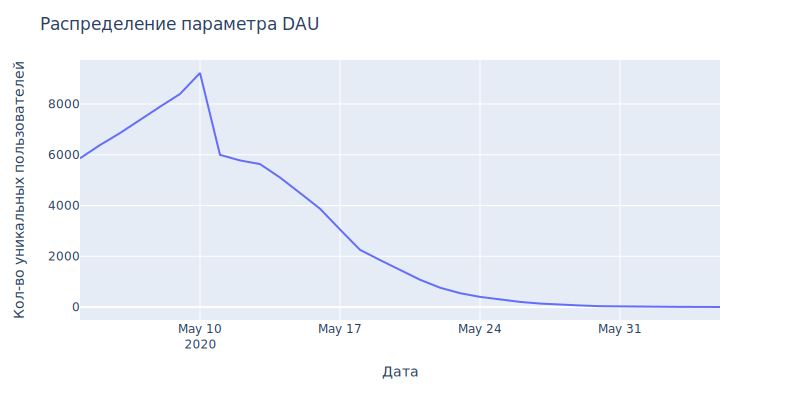

In [9]:
dau = game_actions.groupby('session_date', as_index = False).agg({'user_id': 'nunique'})
fig = px.line(dau, x='session_date', y='user_id', width=800, height=400)
fig.update_layout(
    title='Распределение параметра DAU',
    xaxis_title="Дата",
    yaxis_title="Кол-во уникальных пользователей")
fig.show('svg')

**Вывод:** Из графика видно, что максимальное значение DAU было 10 мая. До этой даты тенденция была восходящая, после нисходящая.

In [10]:
game_actions.to_csv('game_actions')

## 2.2. Retention Rate

Определим первое посещение каждого пользователя:

In [11]:
first_activity_date = game_actions.groupby(['user_id'])['session_date'].min()
first_activity_date.name = 'cohort_group'

Добавим в общую таблицу данные о первом посещении для каждого пользователя:

In [12]:
game_actions = game_actions.join(first_activity_date, on='user_id')

Когорты будем формировать по дням, то время жизни когорты определим разностью дат:

In [13]:
game_actions['cohort_lifetime'] = game_actions['session_date'] - game_actions['cohort_group']

Приведем время жизни когорты к числовому значению:

In [14]:
game_actions['cohort_lifetime'] = game_actions['cohort_lifetime'] / np.timedelta64(1, 'D')
game_actions['cohort_lifetime'] = game_actions['cohort_lifetime'].astype('int')

Для анализа возьмем данные, равные когортам:

In [15]:
game_actions_new = game_actions

Cформируем когорту:

In [16]:
cohorts = game_actions_new.groupby(['cohort_group','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()

Построим когорту и сделаем срез с нулевыми значениями длины жизни:

In [17]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['cohort_group', 'user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'}).reset_index(drop=True)

Объединим данные:

In [18]:
cohorts = cohorts.merge(initial_users_count,on='cohort_group')

Рассчитаем **Retention Rate**, разделив количество активных пользователей в каждый день на исходное число пользователей в когорте:

In [19]:
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']

In [20]:
cohorts['cohort_group'] = cohorts['cohort_group'].dt.strftime('%Y-%m-%d')

In [21]:
retention_pivot = cohorts.pivot_table(
    index='cohort_group',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)

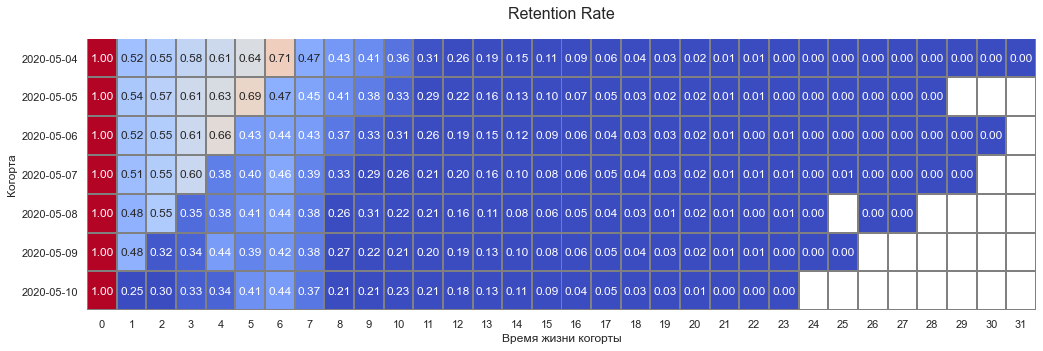

In [22]:
sns.set(style='white')
plt.figure(figsize=(17, 5))
plt.title('Retention Rate', fontsize=16, pad=20)
sns.heatmap(retention_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap= 'coolwarm', cbar=False, vmin = 0.3);
plt.xlabel('Время жизни когорты', fontsize=12)
plt.ylabel('Когорта', fontsize=12);

**Вывод:** На каждом времени жизни разных когорт RR приблизительно одинаковы, что говорит о правильном выборе источников трафика. С увеличением времени жизни когорты, RR увеличивается, о чем можно предположить, что пользователям отсылают Push-уведомления о напоминании данного приложения.

## 2.3. Распределение кол-ва пользователей по источникам

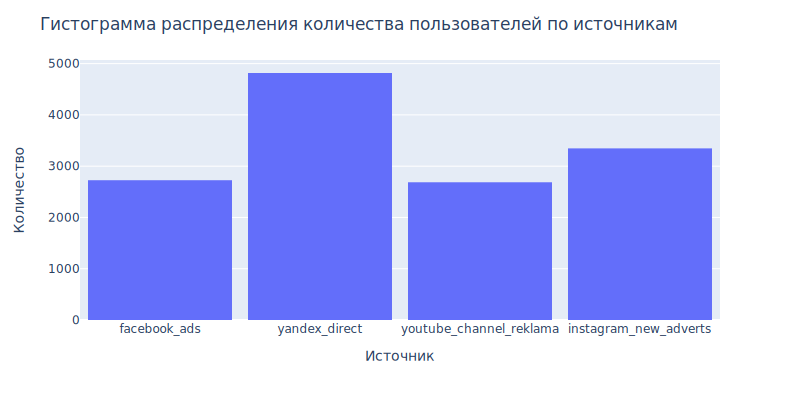

In [23]:
fig = px.histogram(user_source, x='source', width=800, height=400)
fig.update_layout(bargap=0.1)
fig.update_layout(
    title='Гистограмма распределения количества пользователей по источникам',
    xaxis_title="Источник",
    yaxis_title="Количество")
fig.show('svg')

**Вывод:** Наибольшее количество пользователей пришло с Яндекса, а наименьшее - Ютуба.

# Шаг 3. Маркетинговые метрики

## 3.1. Общая сумма расходов. Траты по источникам

Возьмем, что расходы на маркетинг измеряются в долларах.

In [24]:
costs_group = ad_costs.groupby('day', as_index=False).agg({'cost':'sum'})

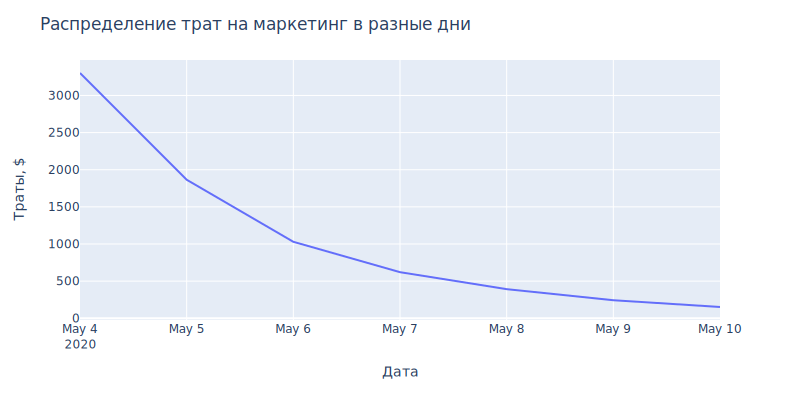

In [25]:
fig = px.line(costs_group, x='day', y='cost', width=800, height=400)
fig.update_layout(
    title='Распределение трат на маркетинг в разные дни',
    xaxis_title="Дата",
    yaxis_title="Траты, $")
fig.show('svg')

**Вывод:** С каждым днем траты на привлечение новых клиентов уменьшалось и прекратились 10 мая. Сопоставив данный грфик с DAU, можно понять, почему после 10 мая DAU иммеет нисходящий характер - прекратилась работа рекламной компании.

In [26]:
total_cost = ad_costs['cost'].sum()
print('Общая сумма потраченная на маркетинг = {:.0f} $'.format(total_cost))

Общая сумма потраченная на маркетинг = 7604 $


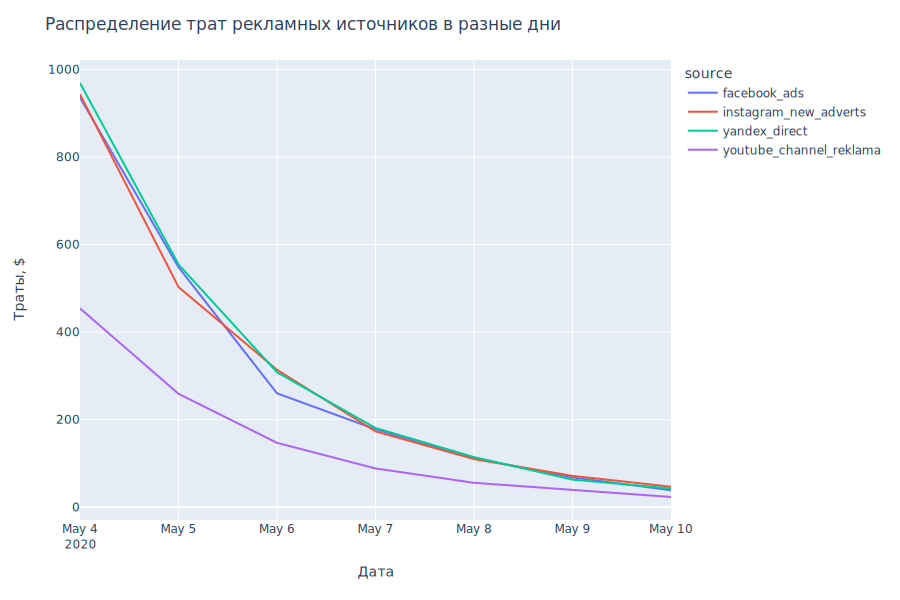

In [27]:
fig = px.line(ad_costs, x="day", y="cost", color='source', width=900, height=600)
fig.update_layout(
    title='Распределение трат рекламных источников в разные дни ',
    xaxis_title="Дата",
    yaxis_title="Траты, $")
fig.show('svg')

**Вывод:** Самый маленький бюджет рекламы с Ютуб-каналов. Все остальные источники трафика распределены приблизительно одинаково. 

## 3.2. САС - стоимость клиента

Определим когорты и траты на их привлечение:

In [28]:
costs_day = (
    ad_costs.groupby('day')
    .agg({'cost':'sum'})
    .reset_index()
)
costs_day.columns = ['cohort_group', 'cost']

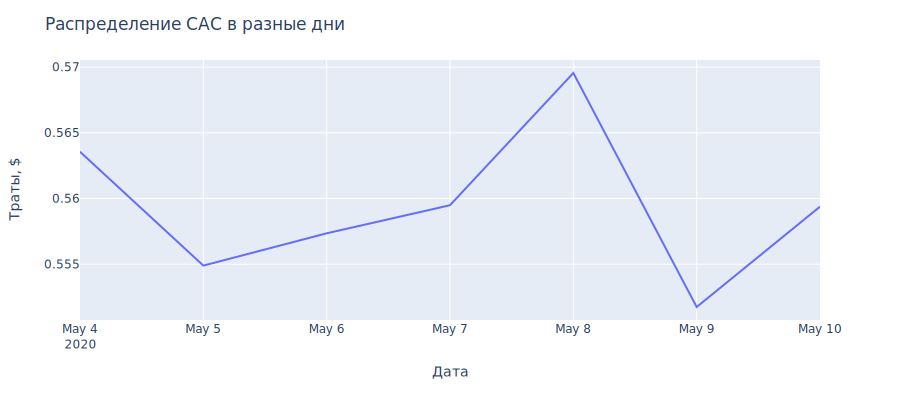

In [29]:
#Смержим данне о количестве пользователей в когорте и их сумму маркетинговых трат
orders_costs = initial_users_count.merge(costs_day, on ='cohort_group')
#Определим стоимость привлечения одного клиента
orders_costs['cac'] = orders_costs['cost'] / orders_costs['cohort_users']

fig = px.line(orders_costs, x='cohort_group', y='cac', width=900, height=400)
fig.update_layout(
    title='Распределение CAC в разные дни',
    xaxis_title="Дата",
    yaxis_title="Траты, $")
fig.show('svg')

**Вывод:** 8 мая для компании привлечение клиента стало самым дорогим, 9 мая - самым дешевым.

## 3.3. САС - стоимость клиента в разрезе источников

Смержим таблицу основных данных о пользователях с таблицой источник:

In [30]:
game_actions_source = game_actions.merge(user_source, on='user_id')

Посчитаем количество пользователей в каждый день: 

In [31]:
cohorts_source = game_actions_source.groupby(
    ['cohort_group','cohort_lifetime','source'], as_index = False).agg({'user_id':'nunique'})

Определим количество уникальных пользователей по источникам в каждой когорте:

In [32]:
initial_users_count_source = cohorts_source[cohorts_source['cohort_lifetime'] == 0][['cohort_group','source', 'user_id']]
initial_users_count_source = initial_users_count_source.rename(columns={'user_id':'cohort_users'}).reset_index(drop=True)

Определим траты на рекламу по источникам в каждой когорте и смержим с таблицей о количестве пользователей:

In [33]:
costs_day_source = (
    ad_costs.groupby(['day','source'])
    .agg({'cost':'sum'})
    .reset_index()
)
costs_day_source.columns = ['cohort_group', 'source', 'cost']
orders_costs_source = initial_users_count_source.merge(costs_day_source, on =['cohort_group', 'source'])

Рассчитаем САС и построим график:

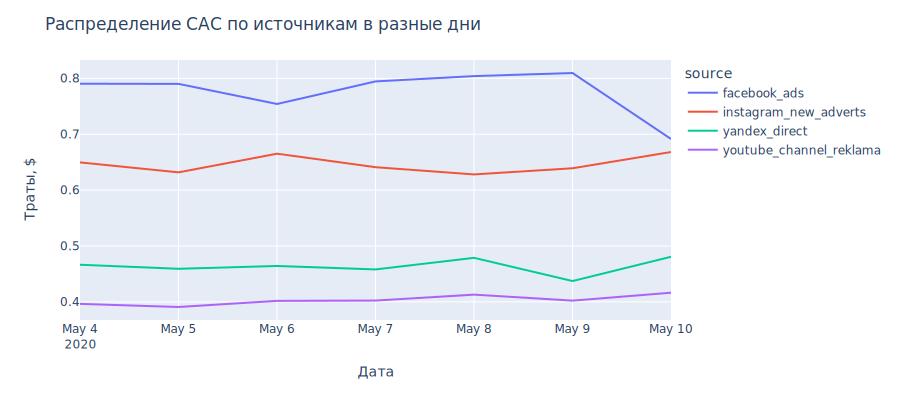

In [34]:
orders_costs_source['cac'] = orders_costs_source['cost'] / orders_costs_source['cohort_users']
fig = px.line(orders_costs_source, x='cohort_group', y='cac', color = 'source', width=900, height=400)
fig.update_layout(
    title='Распределение CAC по источникам в разные дни ',
    xaxis_title="Дата",
    yaxis_title="Траты, $")
fig.show('svg')

**Вывод:** Рассмотрев стоимость привлечения клиента с разных источников, увидели, что клиенты с Фейсбука явялются самыми дорогими, в то время, как пользователи с Ютуба явялются самыми дешевыми.

Определим среднее значение CAC по источникам:

In [35]:
orders_costs_source.groupby('source', as_index=False).agg({'cac':'mean'})

,source,cac
0,facebook_ads,0.776358
1,instagram_new_adverts,0.646144
2,yandex_direct,0.463491
3,youtube_channel_reklama,0.403225


## 3.4. ROI (LTV) в разрезе источников

Предположим, что показ рекламы происходит при выборе типа здания `building_type`. Также предположим, что стоимость показа составит **0.07$**.

Напишем функцию для упрощения рассчета выбора лучшего варианта монетизации:

In [36]:
#Сделаем срез данных, согласно нашему условию монетизации:
monetization = game_actions.merge(user_source, on='user_id')
monetization = monetization[game_actions['building_type'].isna() == False]

In [37]:
def mon(monetization, price):    
    '''
    Функция рассчитывает окупаемость маркетинговых расходов по разным источникам трафика
    '''
    price=0.07
    #Посчитаем количество пользователей по дню и по источнику:
    mon_source = monetization.groupby(['session_date', 'source'], as_index = False).agg({'user_id':'count'})
    mon_source.rename(columns={'user_id': 'source_n_buyers'}, inplace=True)

    #Смержим полученные данные с таблицей расходов на маркетинг:
    report_source = mon_source.merge(ad_costs, how='left', left_on=['session_date', 'source'], \
                                                  right_on=['day','source'])

    #Для удобства создадим столбец с новый отчетом дат, начиная с 4 мая:
    report_source['dt'] = (report_source['session_date'] \
                       - pd.to_datetime('2020-05-04', format='%Y-%m-%d')).astype('timedelta64[D]')
    report_source['dt'] = report_source['dt'].astype(int)

    #Удалим лишний столбец и заполним пустые значения столбца cost нулями:
    report_source = report_source.drop(['day'], axis = 1)
    report_source['cost'] = report_source['cost'].fillna(0)

    #Посчитаем доход:
    report_source['profit'] = round(report_source['source_n_buyers'] * price, 1)

    #Посчитаем прибыль:
    report_source['income'] = round(report_source['profit'] - report_source['cost'], 1)

    #Создадим сводную таблицу и построим пот ней тепловую карту прибыли:
    income_source = report_source.pivot_table(index='source', columns='dt', values='income', aggfunc='mean')
    income_source = income_source.cumsum(axis=1)
    income_source = income_source.T

    #График
    sns.set(style='white')
    plt.figure(figsize=(8, 15))
    plt.title('Прибыль', fontsize=16, pad=20)
    sns.heatmap(income_source, annot=True, fmt='.1f', linewidths=1, linecolor='gray', cmap= 'coolwarm', cbar=False, vmax = 0);
    plt.xlabel('Источник', fontsize=12)
    plt.ylabel('День', fontsize=12);

    #Рассмотрим прибыль в общей картине:
    income = report_source.groupby('dt', as_index = False).agg({'income':'sum'})
    income = income.cumsum()

    #График
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=income.index,
                             y=income['income'],
                             line=dict(color='blue', width=2)))
    fig.update_layout(title='График изменения прибыли',
                      xaxis_title='День',
                      yaxis_title='Прибыль, $')
    fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='#008000')
    fig.show('svg')

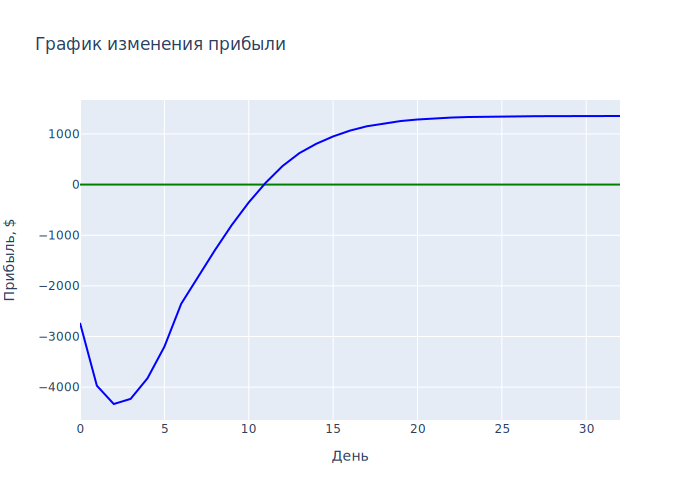

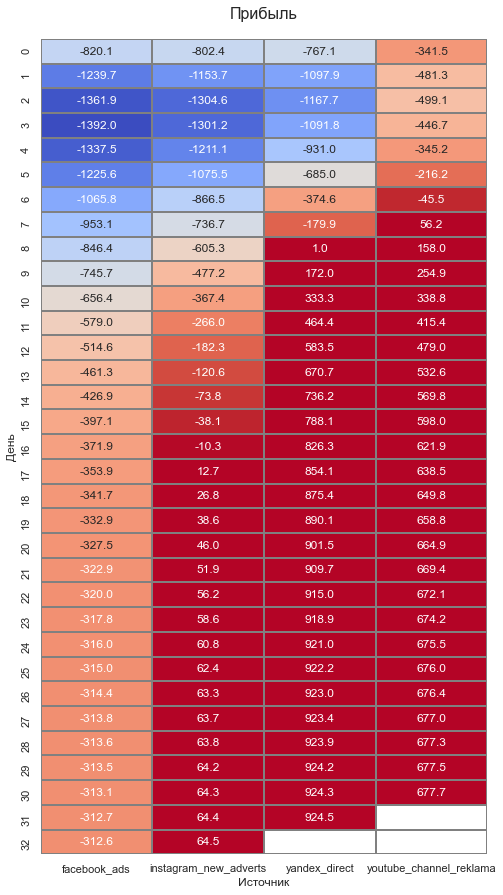

In [38]:
mon(monetization, 0.07)

**Вывод:** При данном способе монетизации мы увидели, что окупаемость клиентов, пришедших с разных источников, разная. Пользователи, пришедшие с Ютуба и Яндекса в среднем окупаются за 7-8 день, с Инстаграмма - за 17 дней. Однако пользователи, пришедшие с Фейсбука не окупаются за весь исследуемый период. Такой анализ позволил определить целевую аудиторию. При общей картине(без распределения по источникам) окупаемость составляет 11 дней. 

## 3.4. New Монетизация

Можно предложить **Rewarded Video** (вознаграждающее видео) — видео, за просмотр которого пользователю дают награду. Данный ролик можно запускать для всех пользователей, которые ознакомились с инструкцией. При этом стоимость просмотра должна составлять 0.06$, чтоб иметь прибыль.

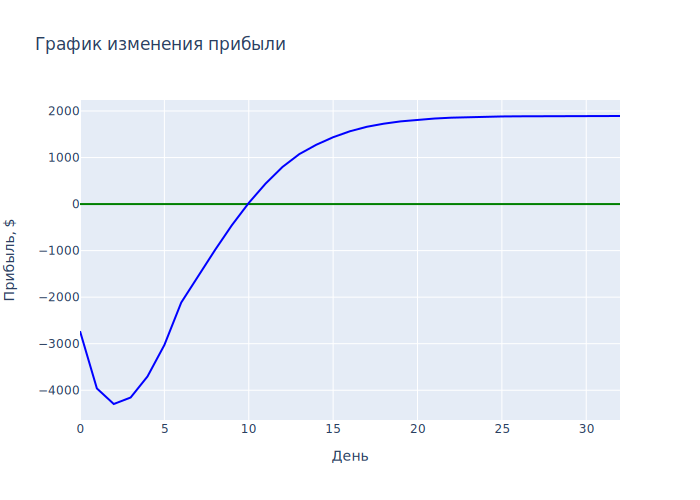

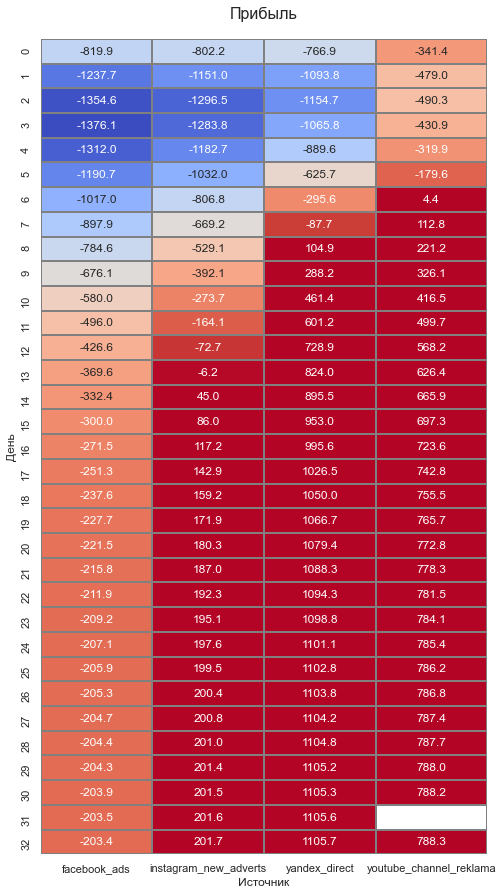

In [39]:
mon(game_actions.merge(user_source, on='user_id'), 0.06)

**Вывод:** Окупаемость данной модели монетизации составит 14 дней. 

# Шаг 4. Статистические гипотезы

## 4.1. Гипотеза 1

Различие времени прохождения уровня между группами пользователей, которые заканчивают уровень через реализацию проекта, и группой пользователей, которые заканчивают уровень победой над другим игроком.

Определим разницу времени (в часах) каждого события у пользователя с момента первого посещения:

In [40]:
pd.options.mode.chained_assignment = None  # default='warn'

first_open = game_actions.groupby('user_id')['event_datetime'].min()
first_open.name = 'first_open'
game_actions = game_actions.merge(first_open, on='user_id')
game_actions['delta_win'] = (game_actions['event_datetime'] - game_actions['first_open']).astype('timedelta64[h]')
game_actions['delta_win'] = game_actions['delta_win'].astype(int)

Сформируем по условию две группы для статистического анализа. Группа B - пользователи, закончившие уровень через победу над другим игроком, а группа A - через реализацию проекта.

In [41]:
#Группа А
win_A = game_actions[game_actions['event'] == 'project']['delta_win']

#Группа В
mask = game_actions[(game_actions['event'] == 'finished_stage_1')]['user_id'].isin(
    game_actions[game_actions['event'] == 'project']['user_id'])

win_B = game_actions[(game_actions['event'] == 'finished_stage_1')].loc[~mask]['delta_win']

**Нулевая гипотеза:** среднее время прохождения уровня между пользователями равны <br>
**Альтернативная гипотеза:** среднее время прохождения уровня между пользователями различается

Выберем альфа = 0.05 - низший уровень статистической значимости, рекомендован для небольших выборок.

In [42]:
alpha = 0.05 # критический уровень статистической значимости
result_1 = st.ttest_ind(win_A,win_B,equal_var=False) 
pvalue_1 = result_1.pvalue
if pvalue_1 < alpha:
    print("P-value = {0:.3f}. Отвергаем нулевую гипотезу".format(pvalue_1))
else:
    print("P-value = {0:.3f}. Не получилось отвергнуть нулевую гипотезу".format(pvalue_1))

P-value = 0.000. Отвергаем нулевую гипотезу


**Вывод:** Отвергаем нулевую гипотезу, среднее время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, разное.

## 4.1. Гипотеза 2

Различие времени прохождения уровня между группами пользователей, которые пришли с Ютуба, и группой пользователей, пришедших с Инстаграмма.

In [43]:
game_actions_source = game_actions.merge(user_source, on='user_id')

In [44]:
win_youtube = game_actions_source[(game_actions_source['event'] == 'finished_stage_1') \
                                    &(game_actions_source['source'] == 'youtube_channel_reklama')]['delta_win']
win_facebook = game_actions_source[(game_actions_source['event'] == 'finished_stage_1') \
                                    &(game_actions_source['source'] == 'instagram_new_adverts')]['delta_win']

**Нулевая гипотеза:** среднее время прохождения уровня между группами одинаково <br>
**Альтернативная гипотеза:** среднее время прохождения уровня между группами различается

In [45]:
result_2 = st.ttest_ind(win_youtube,win_facebook,equal_var=False) 
pvalue_2 = result_2.pvalue
if pvalue_2 < alpha:
    print("P-value = {0:.3f}. Отвергаем нулевую гипотезу".format(pvalue_1))
else:
    print("P-value = {0:.3f}. Не получилось отвергнуть нулевую гипотезу".format(pvalue_1))

P-value = 0.000. Не получилось отвергнуть нулевую гипотезу


**Вывод:** Не получилось отвергнуть нулевую гипотезу, среднее время прохождения уровня между группами пользователей, пришедших с Ютуба и Инстаграмма, равны.

# Вывод

При анализе графика DAU мы увидели резкое снижение активных пользователей. Также об этом свидетельствует Ratention Rate, где резко снижается количество вовлеченных пользователей. Сопоставив графики маркетинговых трат, убедились, что они заканчиваются 10 мая.

При одинаковых тратах на рекламу у Яндекс, Фейсбук и Инстаграмм, наибольшее количество пользователей пришло с Яндекса.
8 мая для компании привлечение клиента стало самым дорогим, 9 мая - самым дешевым. Рассмотрев стоимость привлечения клиента с разных источников, увидели, что клиенты с Фейсбука являются самыми дорогими, в то время, как пользователи с Ютуба являются самыми дешевыми.

Монетизация показа рекламы происходит при выборе типа здания, которая приносит прибыль **0.07$** с одного показа. При данном способе монетизации мы увидели, что окупаемость клиентов, пришедших с разных источников, разная. Пользователи, пришедшие с Ютуба и Яндекса в среднем окупаются за 7-8 дней, с Инстаграмма - за 17 дней. Однако пользователи, пришедшие с Фейсбука не окупаются за весь исследуемый период. Такой анализ позволил определить целевую аудиторию. При общей картине(без распределения по источникам) окупаемость составляет 11 дней. 

Так же исследовав предоставленные данные мы смогли проверить гипотезы. Эти данные помогли нам опровергнуть гипотезу о том, среднее время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, равны. А также получилось подтвердить, что среднее время прохождения уровня между пользователями, пришедших с Ютуба и Инстаграмма, равны.

**Рекомендация:** При данном способе монетизации стоит гораздо больше выделить средства для трафика с Ютуба. Отказаться, от трафика с Фейсбука. Также можно рассмотреть еще один вид монетизации - Rewarded Video. Данный вариант оправдывает себя при стоимости в **0.06$** за 14 дней.

# Материалы

 - Дашборд: <a href='https://public.tableau.com/app/profile/aleksandr3569/viz/FinalBook_16314814329860/Dashboard1?publish=yes'>Ссылка</a>
 